In [2]:
pip install -U keras-tuner

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=a0bba08fa11e26afcc8b8ec7d644cc1c3ca6cb99d8e57c35ae013a1b2e1b5dd1
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=4d909ec4964127cce1d019e934a662b9516a31a38bd6df75136602a5f601be1e
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
cd drive/My\ Drive/Projects/TimeSeriesForecasting

/content/drive/My Drive/Projects/TimeSeriesForecasting


In [0]:
import os
import json
import numpy as np
import pandas as po
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [0]:
import tensorflow as tf
from kerastuner.tuners.bayesian import BayesianOptimization

In [0]:
os.makedirs('forecasts', exist_ok=True)
os.makedirs('forecasts/full_testing_length', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time', exist_ok=True)

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [0]:
class Args:
  def __init__(self):
    self.val_start = 12*24*250
    self.test_start = 12*24*300
    self.train_seq_len = 12*24*7
    self.val_seq_len = 12*24
    
    self.batch_size = 1024
    self.num_epochs = 50
    
    self.subsequences = self.train_seq_len//(12*24)
    #self.conv_num_channels = 128
    #self.pool_size = 12
    self.lstm_hidden_dim = 100

    self.save_folder = 'tune_CNN_LSTM'
    self.logs_dir = 'model_checkpoints/' + self.save_folder + '/logs_dir'

In [0]:
args = Args()

In [0]:
os.makedirs('plots/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder + '/logs_dir', exist_ok=True)
os.makedirs('forecasts/full_testing_length/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/plots', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results', exist_ok=True)

In [0]:
train_df = df[: args.val_start]
val_df = df[args.val_start: args.test_start]
test_df = df[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data.values[i - train_seq_len: i].T.tolist())
        y.append(data.values[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [15]:
X_train, y_train = make_windows(train_df)
X_val, y_val = make_windows(val_df)

100%|██████████| 12097/12097 [00:01<00:00, 9320.31it/s]


In [0]:
X_train = X_train.reshape(X_train.shape[0], args.subsequences, -1, 1)
X_val = X_val.reshape(X_val.shape[0], args.subsequences, -1, 1)

In [0]:
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-2, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2)
#best_val = tf.keras.callbacks.ModelCheckpoint('model_checkpoints/' + args.save_folder + '/model_{epoch:02d}.h5', save_best_only=True, mode='min', save_freq='epoch')

In [0]:
def build_model(hp):

  conv_num_channels = hp.Int('num_channels', min_value=50, max_value=200, step=50)
  pool_size = hp.Int('kernel_size', min_value=6, max_value=36, step=6)
  #lstm_hidden_dim = hp.Int('num_channels', min_value=100, max_value=200, step=50)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters = conv_num_channels, kernel_size = 1, activation = 'relu'), input_shape = (None, X_train.shape[2], 1)))
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size = pool_size)))
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
  model.add(tf.keras.layers.LSTM(args.lstm_hidden_dim, activation = 'relu'))
  model.add(tf.keras.layers.Dense(args.val_seq_len))

  model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])

  return model

In [19]:
tuner = BayesianOptimization(
    build_model,
    objective='mean_squared_error',
    max_trials=20,
    executions_per_trial=2,
    directory=args.logs_dir,
    project_name=args.save_folder,
    overwrite = True)

In [20]:
tuner.search_space_summary()

In [21]:
tuner.search(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks = [earlystop], verbose=True)

Epoch 1/50
69/69 [==============================] - 10s 139ms/step - loss: 0.0807 - mean_squared_error: 0.0807 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 2/50
69/69 [==============================] - 9s 133ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 3/50
69/69 [==============================] - 9s 132ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 4/50
69/69 [==============================] - 9s 132ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 5/50
69/69 [==============================] - 9s 134ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 6/50
69/69 [==============================] - 9s 132ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 7/50
69/69 [=========

Epoch 1/50
69/69 [==============================] - 9s 124ms/step - loss: 0.1202 - mean_squared_error: 0.1202 - val_loss: 0.1060 - val_mean_squared_error: 0.1060
Epoch 2/50
69/69 [==============================] - 8s 121ms/step - loss: 0.1177 - mean_squared_error: 0.1177 - val_loss: 0.1037 - val_mean_squared_error: 0.1037
Epoch 3/50
69/69 [==============================] - 9s 124ms/step - loss: 0.1153 - mean_squared_error: 0.1153 - val_loss: 0.1015 - val_mean_squared_error: 0.1015
Epoch 4/50
69/69 [==============================] - 8s 121ms/step - loss: 0.1131 - mean_squared_error: 0.1131 - val_loss: 0.0995 - val_mean_squared_error: 0.0995
Epoch 5/50
69/69 [==============================] - 9s 124ms/step - loss: 0.1110 - mean_squared_error: 0.1110 - val_loss: 0.0976 - val_mean_squared_error: 0.0976
Epoch 6/50
69/69 [==============================] - 8s 122ms/step - loss: 0.1089 - mean_squared_error: 0.1089 - val_loss: 0.0956 - val_mean_squared_error: 0.0956
Epoch 7/50
69/69 [==========

Epoch 1/50
69/69 [==============================] - 4s 63ms/step - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1090 - val_mean_squared_error: 0.1090
Epoch 2/50
69/69 [==============================] - 4s 60ms/step - loss: 0.1216 - mean_squared_error: 0.1216 - val_loss: 0.1079 - val_mean_squared_error: 0.1079
Epoch 3/50
69/69 [==============================] - 4s 61ms/step - loss: 0.1204 - mean_squared_error: 0.1204 - val_loss: 0.1068 - val_mean_squared_error: 0.1068
Epoch 4/50
69/69 [==============================] - 4s 61ms/step - loss: 0.1193 - mean_squared_error: 0.1193 - val_loss: 0.1057 - val_mean_squared_error: 0.1057
Epoch 5/50
69/69 [==============================] - 4s 63ms/step - loss: 0.1182 - mean_squared_error: 0.1182 - val_loss: 0.1047 - val_mean_squared_error: 0.1047
Epoch 6/50
69/69 [==============================] - 4s 61ms/step - loss: 0.1171 - mean_squared_error: 0.1171 - val_loss: 0.1038 - val_mean_squared_error: 0.1038
Epoch 7/50
69/69 [================

Epoch 1/50
69/69 [==============================] - 12s 175ms/step - loss: 0.1207 - mean_squared_error: 0.1207 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 2/50
69/69 [==============================] - 12s 171ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1068 - val_mean_squared_error: 0.1068
Epoch 3/50
69/69 [==============================] - 12s 171ms/step - loss: 0.1194 - mean_squared_error: 0.1194 - val_loss: 0.1062 - val_mean_squared_error: 0.1062
Epoch 4/50
69/69 [==============================] - 12s 172ms/step - loss: 0.1188 - mean_squared_error: 0.1188 - val_loss: 0.1056 - val_mean_squared_error: 0.1056
Epoch 5/50
69/69 [==============================] - 12s 171ms/step - loss: 0.1182 - mean_squared_error: 0.1182 - val_loss: 0.1050 - val_mean_squared_error: 0.1050
Epoch 6/50
69/69 [==============================] - 12s 173ms/step - loss: 0.1176 - mean_squared_error: 0.1176 - val_loss: 0.1044 - val_mean_squared_error: 0.1044
Epoch 7/50
69/69 [====

Epoch 1/50
69/69 [==============================] - 4s 60ms/step - loss: 0.1210 - mean_squared_error: 0.1210 - val_loss: 0.1076 - val_mean_squared_error: 0.1076
Epoch 2/50
69/69 [==============================] - 4s 57ms/step - loss: 0.1203 - mean_squared_error: 0.1203 - val_loss: 0.1069 - val_mean_squared_error: 0.1069
Epoch 3/50
69/69 [==============================] - 4s 59ms/step - loss: 0.1196 - mean_squared_error: 0.1196 - val_loss: 0.1063 - val_mean_squared_error: 0.1063
Epoch 4/50
69/69 [==============================] - 4s 58ms/step - loss: 0.1189 - mean_squared_error: 0.1189 - val_loss: 0.1057 - val_mean_squared_error: 0.1057
Epoch 5/50
69/69 [==============================] - 4s 58ms/step - loss: 0.1182 - mean_squared_error: 0.1182 - val_loss: 0.1050 - val_mean_squared_error: 0.1050
Epoch 6/50
69/69 [==============================] - 4s 58ms/step - loss: 0.1176 - mean_squared_error: 0.1176 - val_loss: 0.1045 - val_mean_squared_error: 0.1045
Epoch 7/50
69/69 [================

Epoch 1/50
69/69 [==============================] - 11s 162ms/step - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1084 - val_mean_squared_error: 0.1084
Epoch 2/50
69/69 [==============================] - 11s 160ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - val_loss: 0.1078 - val_mean_squared_error: 0.1078
Epoch 3/50
69/69 [==============================] - 11s 160ms/step - loss: 0.1206 - mean_squared_error: 0.1206 - val_loss: 0.1073 - val_mean_squared_error: 0.1073
Epoch 4/50
69/69 [==============================] - 11s 160ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1068 - val_mean_squared_error: 0.1068
Epoch 5/50
69/69 [==============================] - 11s 160ms/step - loss: 0.1195 - mean_squared_error: 0.1195 - val_loss: 0.1063 - val_mean_squared_error: 0.1063
Epoch 6/50
69/69 [==============================] - 11s 160ms/step - loss: 0.1190 - mean_squared_error: 0.1190 - val_loss: 0.1058 - val_mean_squared_error: 0.1058
Epoch 7/50
69/69 [====

Epoch 1/50
69/69 [==============================] - 7s 102ms/step - loss: 0.1205 - mean_squared_error: 0.1205 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 2/50
69/69 [==============================] - 7s 101ms/step - loss: 0.1202 - mean_squared_error: 0.1202 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 3/50
69/69 [==============================] - 7s 99ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 0.1068 - val_mean_squared_error: 0.1068
Epoch 4/50
69/69 [==============================] - 7s 98ms/step - loss: 0.1196 - mean_squared_error: 0.1196 - val_loss: 0.1065 - val_mean_squared_error: 0.1065
Epoch 5/50
69/69 [==============================] - 7s 99ms/step - loss: 0.1193 - mean_squared_error: 0.1193 - val_loss: 0.1062 - val_mean_squared_error: 0.1062
Epoch 6/50
69/69 [==============================] - 7s 99ms/step - loss: 0.1190 - mean_squared_error: 0.1190 - val_loss: 0.1059 - val_mean_squared_error: 0.1059
Epoch 7/50
69/69 [==============

Epoch 1/50
69/69 [==============================] - 4s 59ms/step - loss: 0.1205 - mean_squared_error: 0.1205 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 2/50
69/69 [==============================] - 4s 57ms/step - loss: 0.1202 - mean_squared_error: 0.1202 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 3/50
69/69 [==============================] - 4s 59ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 0.1068 - val_mean_squared_error: 0.1068
Epoch 4/50
69/69 [==============================] - 4s 56ms/step - loss: 0.1197 - mean_squared_error: 0.1197 - val_loss: 0.1066 - val_mean_squared_error: 0.1066
Epoch 5/50
69/69 [==============================] - 4s 58ms/step - loss: 0.1194 - mean_squared_error: 0.1194 - val_loss: 0.1063 - val_mean_squared_error: 0.1063
Epoch 6/50
69/69 [==============================] - 4s 56ms/step - loss: 0.1191 - mean_squared_error: 0.1191 - val_loss: 0.1061 - val_mean_squared_error: 0.1061
Epoch 7/50
69/69 [================

Epoch 1/50
69/69 [==============================] - 11s 160ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 0.1068 - val_mean_squared_error: 0.1068
Epoch 2/50
69/69 [==============================] - 11s 157ms/step - loss: 0.1196 - mean_squared_error: 0.1196 - val_loss: 0.1066 - val_mean_squared_error: 0.1066
Epoch 3/50
69/69 [==============================] - 11s 158ms/step - loss: 0.1194 - mean_squared_error: 0.1194 - val_loss: 0.1063 - val_mean_squared_error: 0.1063
Epoch 4/50
69/69 [==============================] - 11s 158ms/step - loss: 0.1191 - mean_squared_error: 0.1191 - val_loss: 0.1061 - val_mean_squared_error: 0.1061
Epoch 5/50
69/69 [==============================] - 11s 158ms/step - loss: 0.1188 - mean_squared_error: 0.1188 - val_loss: 0.1058 - val_mean_squared_error: 0.1058
Epoch 6/50
69/69 [==============================] - 11s 157ms/step - loss: 0.1186 - mean_squared_error: 0.1186 - val_loss: 0.1056 - val_mean_squared_error: 0.1056
Epoch 7/50
69/69 [====

Epoch 1/50
69/69 [==============================] - 7s 97ms/step - loss: 0.1207 - mean_squared_error: 0.1207 - val_loss: 0.1075 - val_mean_squared_error: 0.1075
Epoch 2/50
69/69 [==============================] - 7s 95ms/step - loss: 0.1203 - mean_squared_error: 0.1203 - val_loss: 0.1072 - val_mean_squared_error: 0.1072
Epoch 3/50
69/69 [==============================] - 7s 95ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 0.1068 - val_mean_squared_error: 0.1068
Epoch 4/50
69/69 [==============================] - 7s 95ms/step - loss: 0.1196 - mean_squared_error: 0.1196 - val_loss: 0.1065 - val_mean_squared_error: 0.1065
Epoch 5/50
69/69 [==============================] - 7s 95ms/step - loss: 0.1192 - mean_squared_error: 0.1192 - val_loss: 0.1061 - val_mean_squared_error: 0.1061
Epoch 6/50
69/69 [==============================] - 7s 96ms/step - loss: 0.1188 - mean_squared_error: 0.1188 - val_loss: 0.1058 - val_mean_squared_error: 0.1058
Epoch 7/50
69/69 [================

Epoch 1/50
69/69 [==============================] - 9s 127ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 2/50
69/69 [==============================] - 9s 124ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 0.1069 - val_mean_squared_error: 0.1069
Epoch 3/50
69/69 [==============================] - 9s 125ms/step - loss: 0.1198 - mean_squared_error: 0.1198 - val_loss: 0.1067 - val_mean_squared_error: 0.1067
Epoch 4/50
69/69 [==============================] - 9s 124ms/step - loss: 0.1196 - mean_squared_error: 0.1196 - val_loss: 0.1065 - val_mean_squared_error: 0.1065
Epoch 5/50
69/69 [==============================] - 9s 125ms/step - loss: 0.1194 - mean_squared_error: 0.1194 - val_loss: 0.1064 - val_mean_squared_error: 0.1064
Epoch 6/50
69/69 [==============================] - 9s 125ms/step - loss: 0.1192 - mean_squared_error: 0.1192 - val_loss: 0.1062 - val_mean_squared_error: 0.1062
Epoch 7/50
69/69 [==========

Epoch 1/50
69/69 [==============================] - 9s 130ms/step - loss: 0.1228 - mean_squared_error: 0.1228 - val_loss: 0.1094 - val_mean_squared_error: 0.1094
Epoch 2/50
69/69 [==============================] - 9s 127ms/step - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1090 - val_mean_squared_error: 0.1090
Epoch 3/50
69/69 [==============================] - 9s 129ms/step - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1087 - val_mean_squared_error: 0.1087
Epoch 4/50
69/69 [==============================] - 9s 128ms/step - loss: 0.1217 - mean_squared_error: 0.1217 - val_loss: 0.1084 - val_mean_squared_error: 0.1084
Epoch 5/50
69/69 [==============================] - 9s 127ms/step - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1081 - val_mean_squared_error: 0.1081
Epoch 6/50
69/69 [==============================] - 9s 128ms/step - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1078 - val_mean_squared_error: 0.1078
Epoch 7/50
69/69 [==========

Epoch 1/50
69/69 [==============================] - 9s 137ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 2/50
69/69 [==============================] - 9s 137ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1069 - val_mean_squared_error: 0.1069
Epoch 3/50
69/69 [==============================] - 9s 135ms/step - loss: 0.1198 - mean_squared_error: 0.1198 - val_loss: 0.1067 - val_mean_squared_error: 0.1067
Epoch 4/50
69/69 [==============================] - 9s 135ms/step - loss: 0.1196 - mean_squared_error: 0.1196 - val_loss: 0.1066 - val_mean_squared_error: 0.1066
Epoch 5/50
69/69 [==============================] - 9s 135ms/step - loss: 0.1194 - mean_squared_error: 0.1194 - val_loss: 0.1064 - val_mean_squared_error: 0.1064
Epoch 6/50
69/69 [==============================] - 9s 138ms/step - loss: 0.1192 - mean_squared_error: 0.1192 - val_loss: 0.1062 - val_mean_squared_error: 0.1062
Epoch 7/50
69/69 [==========

Epoch 1/50
69/69 [==============================] - 6s 92ms/step - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.1077 - val_mean_squared_error: 0.1077
Epoch 2/50
69/69 [==============================] - 6s 89ms/step - loss: 0.1206 - mean_squared_error: 0.1206 - val_loss: 0.1075 - val_mean_squared_error: 0.1075
Epoch 3/50
69/69 [==============================] - 6s 91ms/step - loss: 0.1204 - mean_squared_error: 0.1204 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 4/50
69/69 [==============================] - 6s 89ms/step - loss: 0.1203 - mean_squared_error: 0.1203 - val_loss: 0.1072 - val_mean_squared_error: 0.1072
Epoch 5/50
69/69 [==============================] - 6s 90ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 6/50
69/69 [==============================] - 6s 89ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 0.1069 - val_mean_squared_error: 0.1069
Epoch 7/50
69/69 [================

Epoch 1/50
69/69 [==============================] - 11s 157ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - val_loss: 0.1081 - val_mean_squared_error: 0.1081
Epoch 2/50
69/69 [==============================] - 11s 155ms/step - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1079 - val_mean_squared_error: 0.1079
Epoch 3/50
69/69 [==============================] - 11s 154ms/step - loss: 0.1209 - mean_squared_error: 0.1209 - val_loss: 0.1078 - val_mean_squared_error: 0.1078
Epoch 4/50
69/69 [==============================] - 11s 155ms/step - loss: 0.1207 - mean_squared_error: 0.1207 - val_loss: 0.1076 - val_mean_squared_error: 0.1076
Epoch 5/50
69/69 [==============================] - 11s 155ms/step - loss: 0.1206 - mean_squared_error: 0.1206 - val_loss: 0.1075 - val_mean_squared_error: 0.1075
Epoch 6/50
69/69 [==============================] - 11s 156ms/step - loss: 0.1204 - mean_squared_error: 0.1204 - val_loss: 0.1073 - val_mean_squared_error: 0.1073
Epoch 7/50
69/69 [====

Epoch 1/50
69/69 [==============================] - 4s 57ms/step - loss: 0.1213 - mean_squared_error: 0.1213 - val_loss: 0.1081 - val_mean_squared_error: 0.1081
Epoch 2/50
69/69 [==============================] - 4s 55ms/step - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1080 - val_mean_squared_error: 0.1080
Epoch 3/50
69/69 [==============================] - 4s 56ms/step - loss: 0.1210 - mean_squared_error: 0.1210 - val_loss: 0.1079 - val_mean_squared_error: 0.1079
Epoch 4/50
69/69 [==============================] - 4s 55ms/step - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.1077 - val_mean_squared_error: 0.1077
Epoch 5/50
69/69 [==============================] - 4s 55ms/step - loss: 0.1207 - mean_squared_error: 0.1207 - val_loss: 0.1076 - val_mean_squared_error: 0.1076
Epoch 6/50
69/69 [==============================] - 4s 54ms/step - loss: 0.1206 - mean_squared_error: 0.1206 - val_loss: 0.1075 - val_mean_squared_error: 0.1075
Epoch 7/50
69/69 [================

Epoch 1/50
69/69 [==============================] - 7s 100ms/step - loss: 0.1205 - mean_squared_error: 0.1205 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 2/50
69/69 [==============================] - 7s 97ms/step - loss: 0.1204 - mean_squared_error: 0.1204 - val_loss: 0.1073 - val_mean_squared_error: 0.1073
Epoch 3/50
69/69 [==============================] - 7s 98ms/step - loss: 0.1202 - mean_squared_error: 0.1202 - val_loss: 0.1072 - val_mean_squared_error: 0.1072
Epoch 4/50
69/69 [==============================] - 7s 96ms/step - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 5/50
69/69 [==============================] - 7s 97ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1069 - val_mean_squared_error: 0.1069
Epoch 6/50
69/69 [==============================] - 7s 96ms/step - loss: 0.1198 - mean_squared_error: 0.1198 - val_loss: 0.1068 - val_mean_squared_error: 0.1068
Epoch 7/50
69/69 [===============

Epoch 1/50
69/69 [==============================] - 9s 127ms/step - loss: 0.1210 - mean_squared_error: 0.1210 - val_loss: 0.1079 - val_mean_squared_error: 0.1079
Epoch 2/50
69/69 [==============================] - 8s 123ms/step - loss: 0.1209 - mean_squared_error: 0.1209 - val_loss: 0.1078 - val_mean_squared_error: 0.1078
Epoch 3/50
69/69 [==============================] - 8s 123ms/step - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.1076 - val_mean_squared_error: 0.1076
Epoch 4/50
69/69 [==============================] - 8s 123ms/step - loss: 0.1206 - mean_squared_error: 0.1206 - val_loss: 0.1075 - val_mean_squared_error: 0.1075
Epoch 5/50
69/69 [==============================] - 9s 123ms/step - loss: 0.1205 - mean_squared_error: 0.1205 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 6/50
69/69 [==============================] - 8s 123ms/step - loss: 0.1203 - mean_squared_error: 0.1203 - val_loss: 0.1072 - val_mean_squared_error: 0.1072
Epoch 7/50
69/69 [==========

Epoch 1/50
69/69 [==============================] - 12s 169ms/step - loss: 0.1215 - mean_squared_error: 0.1215 - val_loss: 0.1084 - val_mean_squared_error: 0.1084
Epoch 2/50
69/69 [==============================] - 12s 167ms/step - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1083 - val_mean_squared_error: 0.1083
Epoch 3/50
69/69 [==============================] - 11s 166ms/step - loss: 0.1213 - mean_squared_error: 0.1213 - val_loss: 0.1082 - val_mean_squared_error: 0.1082
Epoch 4/50
69/69 [==============================] - 12s 168ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - val_loss: 0.1081 - val_mean_squared_error: 0.1081
Epoch 5/50
69/69 [==============================] - 12s 167ms/step - loss: 0.1211 - mean_squared_error: 0.1211 - val_loss: 0.1080 - val_mean_squared_error: 0.1080
Epoch 6/50
69/69 [==============================] - 12s 167ms/step - loss: 0.1210 - mean_squared_error: 0.1210 - val_loss: 0.1078 - val_mean_squared_error: 0.1078
Epoch 7/50
69/69 [====

Epoch 1/50
69/69 [==============================] - 11s 156ms/step - loss: 0.1210 - mean_squared_error: 0.1210 - val_loss: 0.1079 - val_mean_squared_error: 0.1079
Epoch 2/50
69/69 [==============================] - 11s 153ms/step - loss: 0.1209 - mean_squared_error: 0.1209 - val_loss: 0.1078 - val_mean_squared_error: 0.1078
Epoch 3/50
69/69 [==============================] - 11s 153ms/step - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.1077 - val_mean_squared_error: 0.1077
Epoch 4/50
69/69 [==============================] - 11s 155ms/step - loss: 0.1207 - mean_squared_error: 0.1207 - val_loss: 0.1076 - val_mean_squared_error: 0.1076
Epoch 5/50
69/69 [==============================] - 11s 153ms/step - loss: 0.1206 - mean_squared_error: 0.1206 - val_loss: 0.1075 - val_mean_squared_error: 0.1075
Epoch 6/50
69/69 [==============================] - 11s 153ms/step - loss: 0.1205 - mean_squared_error: 0.1205 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 7/50
69/69 [====

INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.results_summary()

In [34]:
models = tuner.get_best_models(num_models=1)

In [0]:
best_model = models[0]

In [38]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 288, 150)    300       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 9, 150)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1350)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               580400    
_________________________________________________________________
dense (Dense)                (None, 288)               29088     
Total params: 609,788
Trainable params: 609,788
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = best_model.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Epoch 1/50
69/69 [==============================] - 9s 133ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 2/50
69/69 [==============================] - 9s 130ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 3/50
69/69 [==============================] - 9s 130ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 4/50
69/69 [==============================] - 9s 131ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 5/50
69/69 [==============================] - 9s 131ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 6/50
69/69 [==============================] - 9s 130ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 7/50
69/69 [==========

In [48]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
best_model.save_weights('model_checkpoints/' + args.save_folder + '/CNN_LSTM_best_model_{:02d}.h5'.format(best_epoch))
best_epoch

50

In [49]:
X_test, y_test = make_windows(test_df)

100%|██████████| 12097/12097 [00:01<00:00, 9248.70it/s]


In [0]:
X_test = X_test.reshape(X_test.shape[0], args.subsequences, -1, 1)

In [0]:
y_pred = best_model.predict(X_test)

In [0]:
#best_epoch = 25 #load this epoch (performance across epochs measured in respective model training notebook) 
#best_epoch

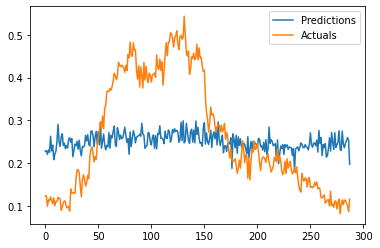

In [53]:
plt.plot(y_pred[288*3])
plt.plot(y_test[288*3])
plt.legend(['Predictions', 'Actuals'])

In [54]:
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  plt.plot(scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)), color = 'blue')
  plt.plot(scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)), color = 'red')
  plt.legend(['Actual Value', 'Prediction'])
  plt.savefig('forecasts/1_day_at_a_time/' + args.save_folder + '/plots/day_{}.png'.format(i))
  plt.close()

  df_t = po.DataFrame()
  df_t['Predictions'] = scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)
  df_t['Actual_Values'] = scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)

  df_t.to_csv('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results/day_{}.csv'.format(i), index = False)

100%|██████████| 42/42 [00:05<00:00,  7.77it/s]


In [55]:
forecasts = []
actuals = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()

100%|██████████| 42/42 [00:00<00:00, 3650.55it/s]


In [0]:
df = po.DataFrame()
df['Predictions'] = forecasts
df['Actual Values'] = actuals

In [0]:
df.to_csv('forecasts/full_testing_length/' + args.save_folder + '/full_results.csv', index = False)

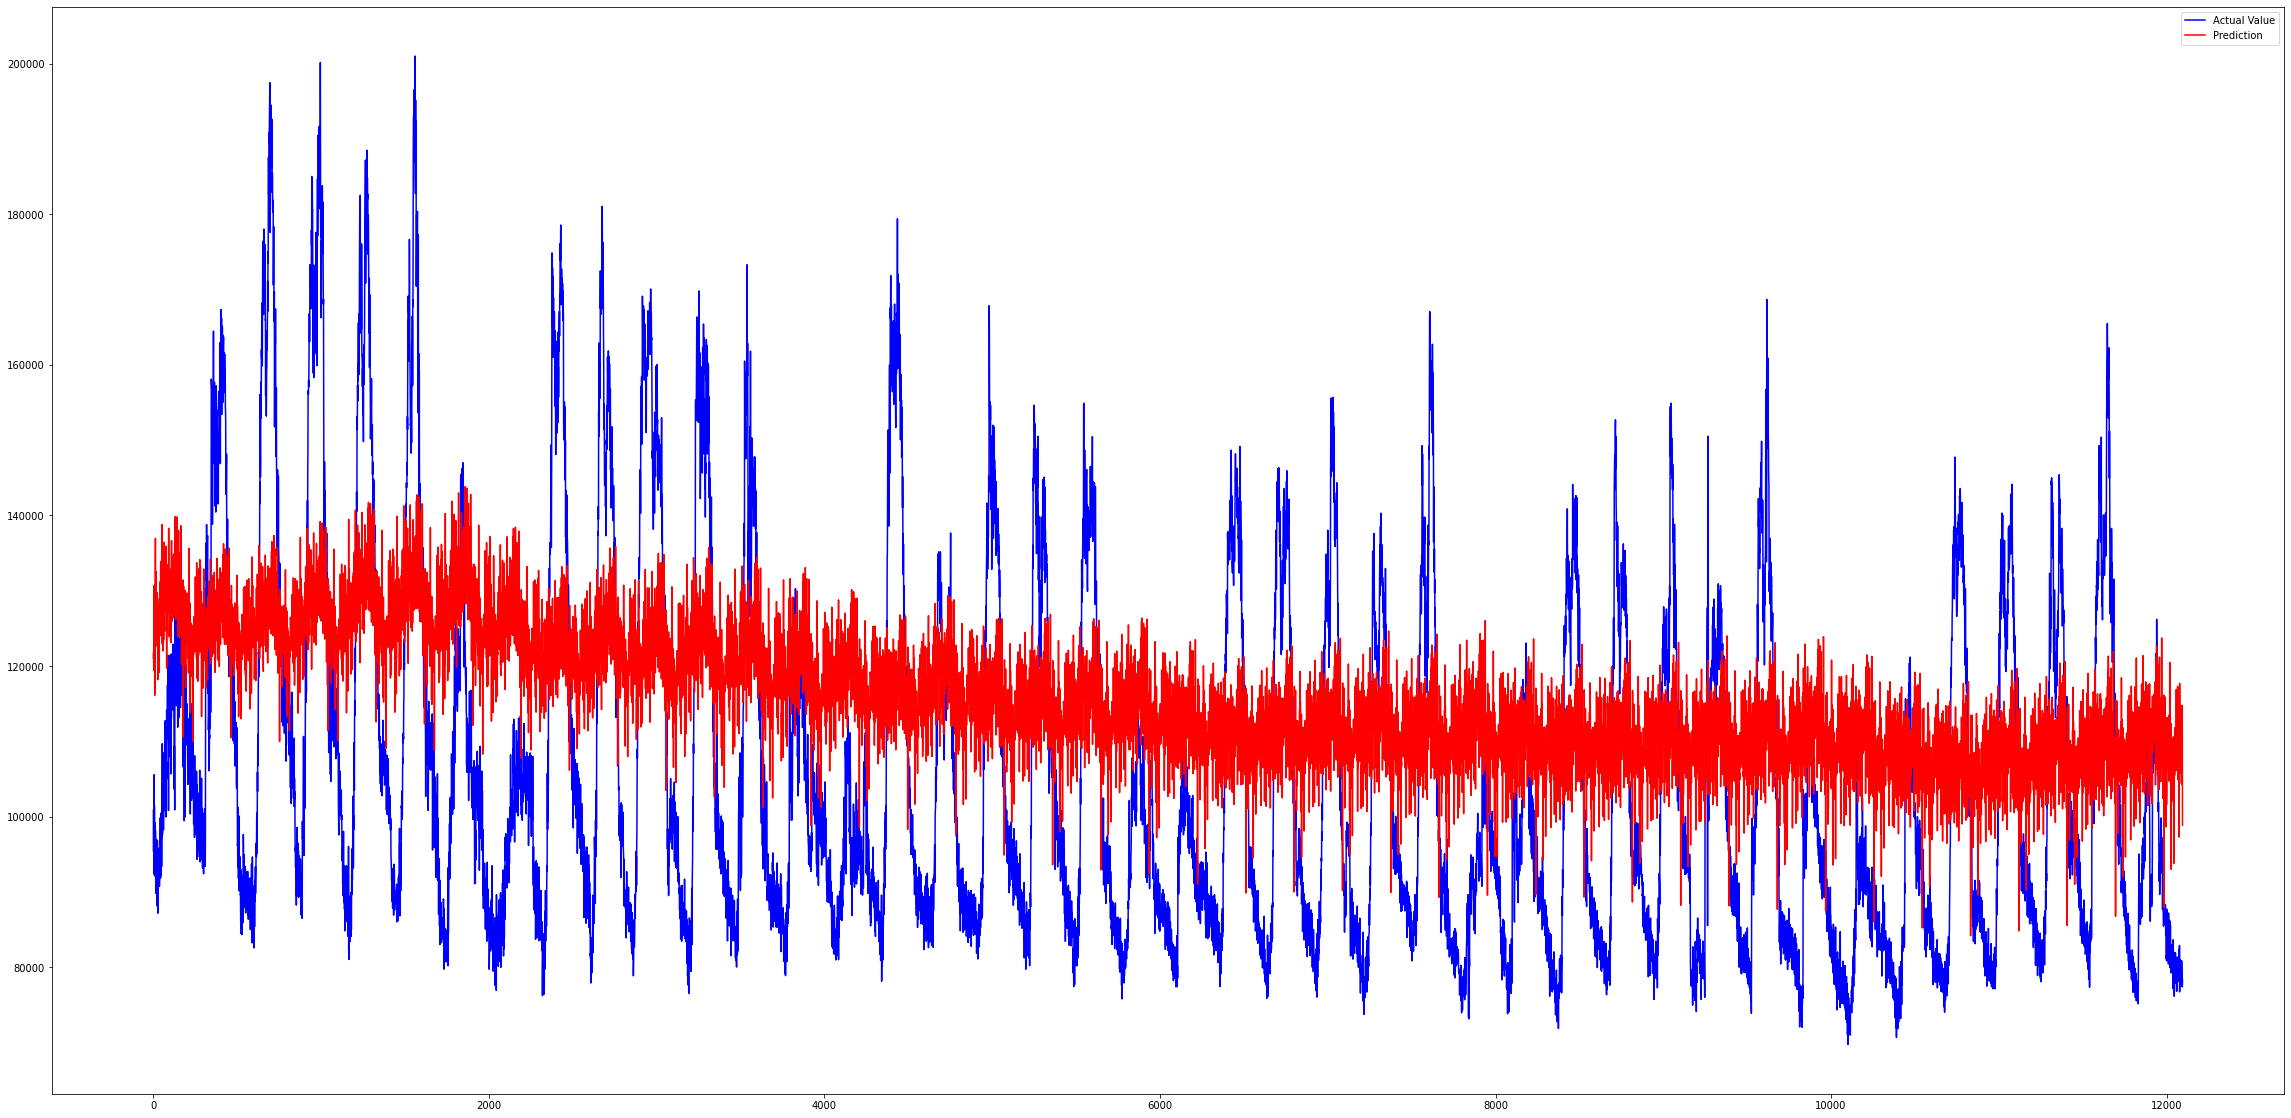

In [58]:
plt.figure(figsize=(40, 20))
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])
plt.savefig('forecasts/full_testing_length/' + args.save_folder + '/forecast.png')

In [0]:
if not os.path.exists('forecasts/full_testing_length/results.csv'):
  results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2', 'MAPE', 'RMSE'])  
else:
  results = po.read_csv('forecasts/full_testing_length/results.csv')

In [0]:
errors = {'model': args.save_folder,
          'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [61]:
results

,model,MAE,MSE,R2,MAPE,RMSE
0,Dilated_CNN,0.037945,0.002629,0.732376,3.794527,0.051273
1,vanillaWaveNet_256_channels,0.046997,0.003457,0.648037,4.699682,0.058799
2,convLSTM,0.040161,0.002803,0.714712,4.016132,0.052941
3,bidirectionalLSTM,0.126920,0.020101,-1.046449,12.691955,0.141780
4,WaveNet,0.049359,0.004077,0.585029,4.935853,0.063849
5,vanillaLSTM,0.134216,0.022371,-1.277546,13.421554,0.149570
6,CNN_LSTM,0.064756,0.005974,0.391845,6.475569,0.077294
7,CNN_LSTM,0.064756,0.005974,0.391845,6.475569,0.077294
8,Dilated_CNN_weekday,0.065784,0.007664,0.599731,6.578448,0.087545
9,Dilated_CNN_weekday,0.049500,0.003988,0.754260,4.950012,0.063152


In [0]:
results.to_csv('forecasts/full_testing_length/results.csv', index=False)

In [0]:
with open('forecasts/full_testing_length/' + args.save_folder + '/params.json', 'w') as f:
  f.write(json.dumps(args.__dict__))
f.close()